## Test the MIRI LRS distortion solution (standalone and JWST pipeline versions)  ##

### Set basic environment stuff ###

In [1]:
import os as os
import numpy as np
from numpy.testing import assert_allclose
import pdb as pdb
import pysiaf

siaf = pysiaf.Siaf('MIRI')

Import the MIRI coordinates code from https://github.com/STScI-MIRI/miricoord and ensure that it is on the PYTHONPATH.  Also ensure that the local data directory environmental variable is set:

setenv MIRICOORD_DATA_DIR /YourLocalPathToData/ (this is where io will happen)

In [2]:
data_dir=os.path.expandvars('$MIRICOORD_DATA_DIR')

### First we'll test the standalone distortion solution (lrs_tools) ###

In [3]:
import miricoord.lrs.lrs_tools as lt

In [4]:
# We should be using FLT-2
lt.version()

'flt2'

In [5]:
# Slitless prism reference point is 37.5, 300.0 in the 0-indexed subarray frame
x,y=37.5,300.
v2,v3,lam=lt.xytov2v3lam(x,y,'slitless')
v2,v3,lam

(-378.63031287257917, -344.89504513102713, array(8.58224656))

In [6]:
# Compare the location to SIAF
siaf['MIRIM_SLITLESSPRISM'].V2Ref,siaf['MIRIM_SLITLESSPRISM'].V3Ref

(-378.630313, -344.895045)

In [7]:
# And print the pysiaf PRD version for reference
print(pysiaf.JWST_PRD_VERSION)

PRDOPSSOC-055


In [8]:
# Slit reference point is 325.13, 299.7 in the 0-indexed full array
x,y=325.13, 299.7
v2,v3,lam=lt.xytov2v3lam(x,y,'slit')
v2,v3,lam

(-414.8779942158295, -400.56817559048847, array(8.34953568))

In [9]:
# Compare the location to SIAF
siaf['MIRIM_SLIT'].V2Ref,siaf['MIRIM_SLIT'].V3Ref

(-414.878, -400.568)

In [10]:
# Test all forward/backward transforms for both slit and slitless
lt.testtransform()

### Now we'll test the pipeline distortion solution (lrs_pipetools) ###

In [11]:
import miricoord.lrs.lrs_pipetools as lpt
lpt.version()

'flt2'

# Slit reference point is 325.13, 299.7 in the 0-indexed full array

In [12]:
x,y=325.13, 299.7
v2,v3,lam=lpt.xytov2v3lam(x,y,'slit')
v2,v3,lam

(-414.8779941458304, -400.56817557579075, 8.349535678413021)

In [13]:
# Test an inverse transform
xnew,ynew=lpt.v2v3lamtoxy(v2,v3,lam,'slit')
xnew,ynew

(325.1266417782534, 299.6991191689394)

In [14]:
# Slitless prism reference point is 37.5, 300.0 in the 0-indexed subarray frame
x,y=37.5,300.
v2,v3,lam=lpt.xytov2v3lam(x,y,'slitless')
v2,v3,lam

(-378.6303128918532, -344.8950450187441, 8.582246561863341)

In [15]:
# Test all forward/backward transforms for both slit and slitless
lpt.testtransform()

### Use simulated files to test the pipeline distortion and bounding boxes

In [16]:
from jwst import datamodels

In [17]:
data_dir=os.path.expandvars('$MIRICOORD_DATA_DIR')
slitfile=data_dir+'testing/jw01033002001_03103_00002_lrsslit_flt1_assignwcsstep.fits'
slitlessfile=data_dir+'testing/jw01033003001_03103_00001-seg001_lrsslitless_flt1_assignwcsstep.fits'

In [18]:
# Slit
im=datamodels.ImageModel(slitfile)
x,y=325.13,299.7
v2,v3,lam=im.meta.wcs.transform("detector", "v2v3", x,y)
v2,v3,lam

(-414.8779941458304, -400.56817557579075, 8.582487525291691)

In [19]:
# Slit bounding box
im.meta.wcs.bounding_box

ModelBoundingBox(
    intervals={
        x0: Interval(lower=301.5, upper=346.5)
        x1: Interval(lower=4.5, upper=394.5)
    }
    model=CompoundModel(inputs=('x0', 'x1'))
    order='C'
)

In [20]:
# This should be different v2, and nearly same v3,lam
x,y=305.13,299.7
v2,v3,lam=im.meta.wcs.transform("detector", "v2v3", x,y)
v2,v3,lam

(-412.6743157696893, -400.74960396508914, 8.586629075744051)

In [21]:
# This should be outside bounding box
x,y=301.13,299.7
v2,v3,lam=im.meta.wcs.transform("detector", "v2v3", x,y)
v2,v3,lam

(nan, nan, nan)

In [22]:
# Slitless
im=datamodels.ImageModel(slitlessfile)
x,y=37.5,300.
v2,v3,lam=im.meta.wcs.transform("detector", "v2v3", x,y)
v2,v3,lam

(-378.6303128918532, -344.8950450187441, 8.58248749838136)

In [23]:
# Slitless bounding box
im.meta.wcs.bounding_box

ModelBoundingBox(
    intervals={
        x0: Interval(lower=3.5, upper=71.5)
        x1: Interval(lower=4.5, upper=394.5)
    }
    model=CompoundModel(inputs=('x0', 'x1'))
    order='C'
)

In [24]:
# This should be different v2, and nearly same v3,lam
x,y=5,300.
v2,v3,lam=im.meta.wcs.transform("detector", "v2v3", x,y)
v2,v3,lam

(-375.0750414490597, -345.21615571458165, 8.589217517845341)

In [25]:
# This should be outside bounding box
x,y=2.5,300.
v2,v3,lam=im.meta.wcs.transform("detector", "v2v3", x,y)
v2,v3,lam

(nan, nan, nan)

### Make some images showing isopleths of the LRS solution

In [26]:
from astropy.io import fits
from numpy import matlib as mb
import matplotlib as mpl
import matplotlib.pyplot as plt

In [27]:
# Slit
im=datamodels.ImageModel(slitfile)
xrow=np.mgrid[0:im.meta.subarray.xsize]
yrow=np.mgrid[0:im.meta.subarray.ysize]
xall=mb.repmat(xrow,im.meta.subarray.ysize,1)
hdux = fits.PrimaryHDU(data=xall)
yall=mb.repmat(yrow,im.meta.subarray.xsize,1)
yall=np.transpose(yall)
hduy = fits.PrimaryHDU(data=yall)
v2all,v3all,lamall=im.meta.wcs.transform("detector","v2v3",xall,yall)

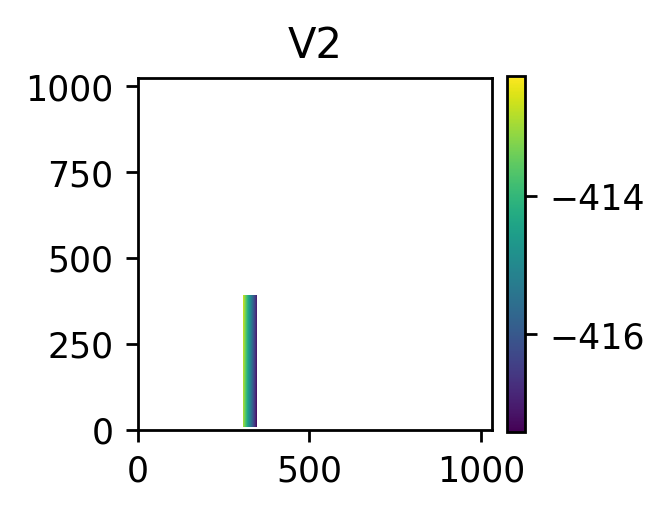

In [28]:
plt.figure(figsize=(2,2),dpi=250)
plt.title('V2')
plt.imshow(v2all,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

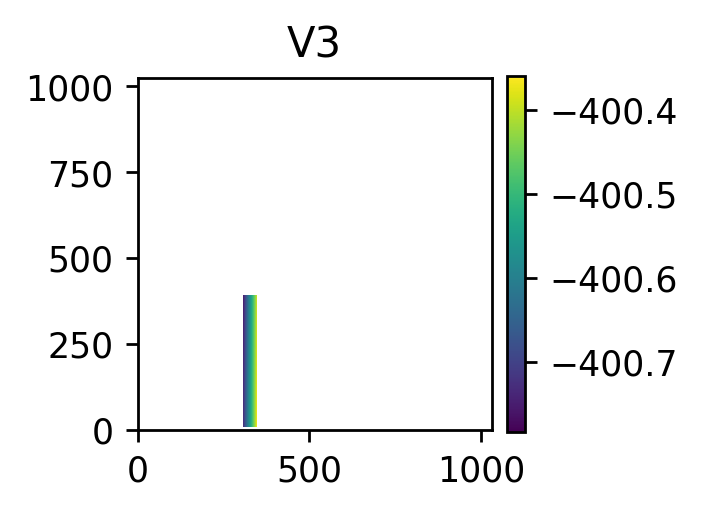

In [29]:
plt.figure(figsize=(2,2),dpi=250)
plt.title('V3')
plt.imshow(v3all,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

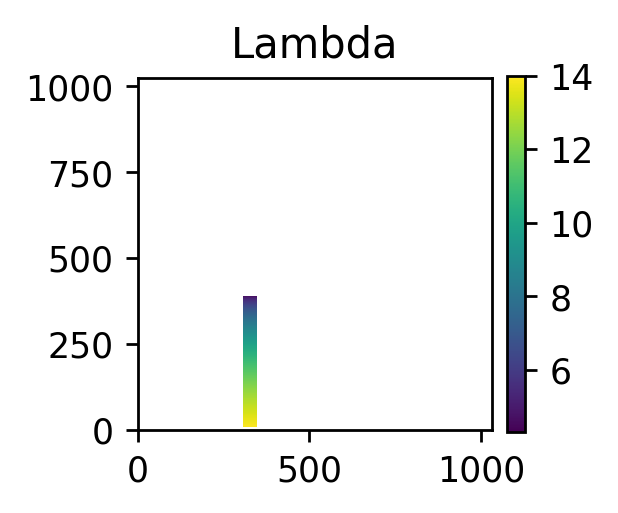

In [30]:
plt.figure(figsize=(2,2),dpi=250)
plt.title('Lambda')
plt.imshow(lamall,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

In [31]:
# Slitless
im=datamodels.ImageModel(slitlessfile)
xrow=np.mgrid[0:im.meta.subarray.xsize]
yrow=np.mgrid[0:im.meta.subarray.ysize]
xall=mb.repmat(xrow,im.meta.subarray.ysize,1)
hdux = fits.PrimaryHDU(data=xall)
yall=mb.repmat(yrow,im.meta.subarray.xsize,1)
yall=np.transpose(yall)
hduy = fits.PrimaryHDU(data=yall)
v2all,v3all,lamall=im.meta.wcs.transform("detector","v2v3",xall,yall)

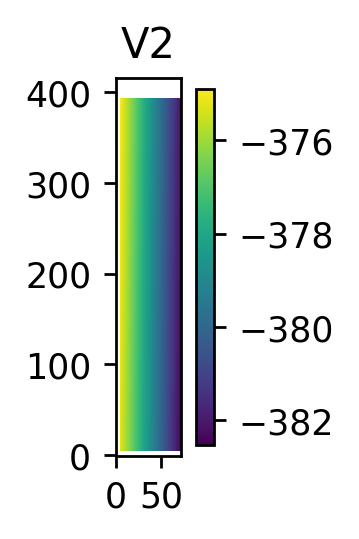

In [32]:
plt.figure(figsize=(2,2),dpi=250)
plt.title('V2')
plt.imshow(v2all,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

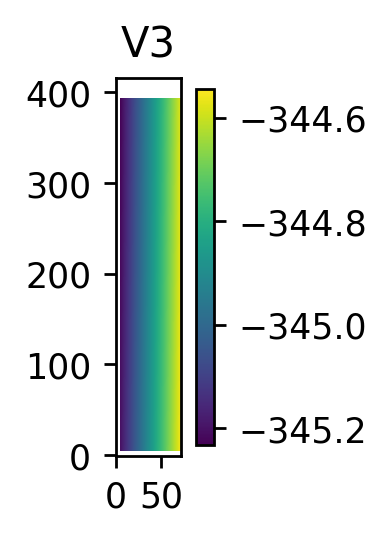

In [33]:
plt.figure(figsize=(2,2),dpi=250)
plt.title('V3')
plt.imshow(v3all,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

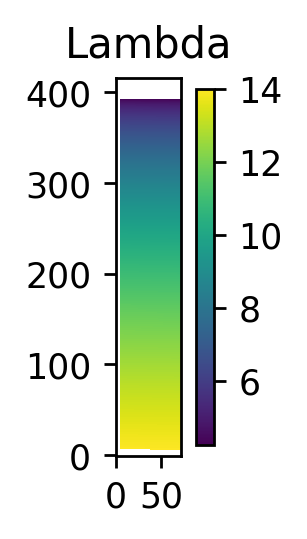

In [34]:
plt.figure(figsize=(2,2),dpi=250)
plt.title('Lambda')
plt.imshow(lamall,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)